## Running this notebook

You can launch this notebook using mybinder by clicking the button below.

<a href="https://mybinder.org/v2/gh/US-GHG-Center/ghgc-docs/HEAD?labpath=user_data_notebooks/epa_ch4_data_notebook.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

A team at Harvard University along with EPA and other coauthors developed a gridded inventory of U.S. anthropogenic methane emissions with 0.1° x 0.1° spatial resolution, monthly temporal resolution, and detailed scale-dependent error characterization. The inventory is designed to be consistent with the 2016 U.S. EPA Inventory of U.S. Greenhouse Gas Emissions and Sinks estimates for the year 2012, which presents national totals for different source types. The gridded inventory was developed using a wide range of databases at the state, county, local, and point source level to allocate the spatial and temporal distribution of emissions for individual source types. This data can be used by researchers to better compare the national-level inventory with measurement results that may be at other scales. Users of this gridded inventory are asked to cite the original reference (Maasakkers et al., 2016) in their publications. Error estimates are given in that reference.

# Installing the Required Libraries
Please run the next cell to install all the required libraries to run the notebook.

## Querying the STAC API

In [78]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [79]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://dev.ghg.center/api/stac"
RASTER_API_URL = "https://dev.ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for gridded methane dataset. 
collection_name = "epa-ch4-v2-annual"

In [80]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'epa-ch4-v2-annual',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'}],
 'title': 'Gridded annual U.S. anthropogenic methane emissions 2012-2018',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-129.99999694387628,
     19.99999923487448,
     -60.00000305612369,
     55.00000076512553]]},
  'temporal': {'interval': [['2012-01-01 00:00:00+00',
     '2018-01-01 00:00:00+00']]}},
 'license': 'CC-BY-4.0',
 'keywords': N

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2000 to December 2021. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [81]:
# Check total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=300").json()["features"]
print(f"Found {len(items)} items")

Found 7 items


In [82]:
# Examining the first item in the collection
items[0]

{'id': 'epa-ch4-v2-annual-2018',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual/items/epa-ch4-v2-annual-2018'}],
 'assets': {'dwtd-waste': {'href': 's3://ghgc-data-store-dev/epa_emissions/Gridded_GHGI_emi_ch4_5D_Wastewater_Treatment_Domestic_Methane_v2_2018.tif',
   'type': 'image/tiff; application=geotiff; p

This makes sense as there are 22 years between 2000 - 2021, with 12 months per year, meaning 264 records in total.  

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in Methane (CH4) Levels Using the Raster API

In this notebook, we will explore the impacts of methane emissions and by examining changes over time in urban regions. We will visualize the outputs on a map using `folium.`

In [83]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:7]: item for item in items} 
asset_name = "surface-coal"

In [84]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [85]:
items

{'2018-01': {'id': 'epa-ch4-v2-annual-2018',
  'bbox': [-129.99999694387628,
   19.99999923487448,
   -60.00000305612369,
   55.00000076512553],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual/items/epa-ch4-v2-annual-2018'}],
  'assets': {'dwtd-waste': {'href': 's3://ghgc-data-store-dev/epa_emissions/Gridded_GHGI_emi_ch4_5D_Wastewater_Treatment_Domestic_Methane_v2_2018.tif',
    'type': 'ima

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2001 and again for December 2021, so that we can visualize each event independently.

In [86]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
december_2001_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2018-01']['collection']}&item={items['2018-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2001_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4-v2-annual&item=epa-ch4-v2-annual-2018&assets=surface-coal&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0.0%2C97066218946560.0'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [87]:
december_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2012-01']['collection']}&item={items['2012-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4-v2-annual&item=epa-ch4-v2-annual-2012&assets=surface-coal&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0.0%2C97066218946560.0'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

## Visualizing CH4 emissions


In [88]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CH4 Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# December 2001
map_layer_2001 = TileLayer(
    tiles=december_2001_tile["tiles"][0],
    attr="GHG",
    opacity=0.7,
)
map_layer_2001.add_to(map_.m1)

# December 2021
map_layer_2021 = TileLayer(
    tiles=december_2021_tile["tiles"][0],
    attr="GHG",
    opacity=0.7,
)
map_layer_2021.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [89]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [90]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [91]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 7 items


In [92]:
# Explore the first item
items[0]

{'id': 'epa-ch4-v2-annual-2018',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/epa-ch4-v2-annual/items/epa-ch4-v2-annual-2018'}],
 'assets': {'dwtd-waste': {'href': 's3://ghgc-data-store-dev/epa_emissions/Gridded_GHGI_emi_ch4_5D_Wastewater_Treatment_Domestic_Methane_v2_2018.tif',
   'type': 'image/tiff; application=geotiff; p

In [93]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

With the function above we can generate the statistics for the AOI.

In [94]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 92.5 ms, sys: 10.7 ms, total: 103 ms
Wall time: 1.7 s


In [95]:
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 3781419073536.0,
   'mean': 1355262426.9755113,
   'count': 3471.0,
   'sum': 4704115884032.0,
   'std': 65897709009.92058,
   'median': 0.0,
   'majority': 0.0,
   'minority': 40393875456.0,
   'unique': 4.0,
   'histogram': [[3469.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.0,
     378141900800.0,
     756283801600.0,
     1134425669632.0,
     1512567603200.0,
     1890709536768.0,
     2268851339264.0,
     2646993272832.0,
     3025135206400.0,
     3403277139968.0,
     3781419073536.0]],
   'valid_percent': 96.42,
   'masked_pixels': 129.0,
   'valid_pixels': 3471.0,
   'percentile_2': 0.0,
   'percentile_98': 0.0}},
 'datetime': '2018-01-01T00:00:00+00:00'}

In [96]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2018-01-01T00:00:00+00:00,0.0,3.781419e+12,1.355262e+09,3471.0,4.704116e+12,6.589771e+10,0.0,0.0,4.039388e+10,4.0,"[[3469.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",96.42,129.0,3471.0,0.0,0.0,2018-01-01 00:00:00+00:00
1,2017-01-01T00:00:00+00:00,0.0,4.789049e+12,2.677184e+09,3471.0,9.292507e+12,9.832945e+10,0.0,0.0,5.375091e+11,5.0,"[[3467.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0...",96.42,129.0,3471.0,0.0,0.0,2017-01-01 00:00:00+00:00
2,2016-01-01T00:00:00+00:00,0.0,4.038696e+12,2.922729e+09,3471.0,1.014479e+13,9.147273e+10,0.0,0.0,5.864952e+11,6.0,"[[3466.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0...",96.42,129.0,3471.0,0.0,0.0,2016-01-01 00:00:00+00:00
3,2015-01-01T00:00:00+00:00,0.0,3.533850e+12,2.680872e+09,3471.0,9.305307e+12,8.247640e+10,0.0,0.0,6.078995e+11,6.0,"[[3466.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0...",96.42,129.0,3471.0,0.0,0.0,2015-01-01 00:00:00+00:00
4,2014-01-01T00:00:00+00:00,0.0,4.119798e+12,3.441581e+09,3471.0,1.194573e+13,1.011587e+11,0.0,0.0,8.512314e+11,6.0,"[[3466.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0...",96.42,129.0,3471.0,0.0,0.0,2014-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the gridded methane emission (Domestic Wastewater Treatment & Discharge (5D)) time series (January 2000 -December 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO2 emission Values for Texas, Dallas (2000-2021)')

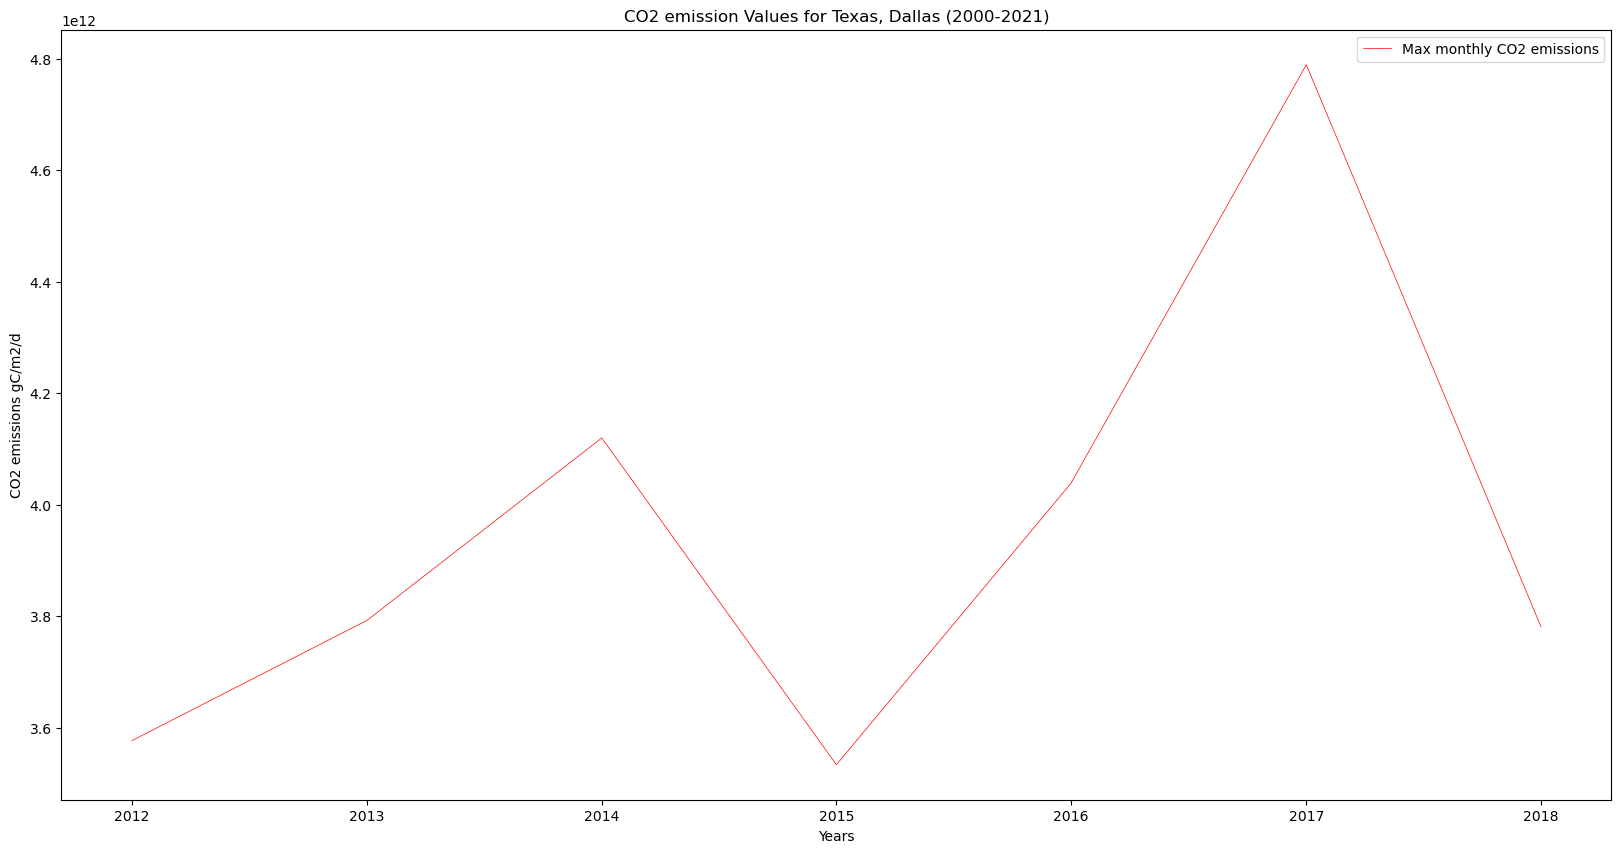

In [97]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO2 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CH4 emissions Mg/a/km2")
plt.title("CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2000-2021)")

In [98]:
print(items[2]["properties"]["datetime"])

2016-01-01T00:00:00+00:00


In [99]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4-v2-annual&item=epa-ch4-v2-annual-2016&assets=surface-coal&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0.0%2C97066218946560.0'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [100]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.5
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for gridded methane emissions.